# Model Predictive Control Rocket Soft-Landing Problem

This notebook is a walkthough of the ALTRO solver for the MPC Rocket Soft-Landing Problem (i.e. the general control challenge of landing a rocket at rest at a designated landing site). In the simplest case, we treat the rocket as a sphere landing on a flat surface with no atmosphere. This approximation is reasonable when the rocket is near the ground and entering the final part of the descent.

**This files focuses on the MPC problem and comparing the result to other solvers. For the simple (non-MPC) application, please visit the <code>RocketLandingSimplified.ipynb</code> file. Thanks!**

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

 Activating environment at `C:\Users\Daniel N\.julia\dev\altro-mpc-icra2021\benchmarks\rocket_landing\Project.toml`


## MPC Problem Outline

For the MPC application, we must fulfill two critical steps:
1. Solve the optimal trajectory and apply the required controls (usually a short horizon)
2. Use the prior trajectory to warm-start the next solve

In this Jupyter notebook, we will:
1. Set up the rocket soft-landing problem 
2. Solve the initial trajectory optimization problem
3. Execute the control (and propagate forward in time)
4. Warm-Start the next iteration
5. Solve the next trajectory optimization problem
6. Repeat steps 3-5 until arrival at the landing location

# Step 1: Set-Up the Rocket Soft-Landing Problem

## Load Required Packages

The <code>RobotDynamics</code> package enables us to define the rocket model and dynamics. The <code>TrajectoryOptimization</code> and <code>Altro</code> set-up and solve the trajectory optimization problem. <code>StaticArrays</code> and <code>LinearAlgebra</code> are required to set-up the appropriate data types.

Next, <code>Plots, MeshCat, TrajOptPlots, FileIO,</code> and <code>MeshIO</code> packages are used to visualize the results. Note that the plotting sections will take significantly longer to run than the optimization. 

Lastly, <code>DifferentialEquations</code> integrates the dynamics forward as a way to show that the dynamics constraints are satisfied.

Loading all the packages, especially for plotting and the differential equations integrator can be the longest part of the whole notebook.

In [2]:
using RobotDynamics
import RobotDynamics: dynamics
using Rotations
using TrajectoryOptimization, Altro
using StaticArrays, LinearAlgebra
println("Trajectory Optimization Packages Ready")

using Plots
pyplot()
println("Base Plotting Packages Ready")

using MeshCat, TrajOptPlots
using FileIO, MeshIO
println("3D Plotting Packages Ready")

import DifferentialEquations.solve, DifferentialEquations.ODEProblem, DifferentialEquations.Tsit5
using BenchmarkTools
println("Differential Equations Ready")

┌ Info: Precompiling TrajectoryOptimization [c79d492b-0548-5874-b488-5a62c1d9d0ca]
└ @ Base loading.jl:1260
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Info: Precompiling Altro [5dcf52e5-e2fb-48e0-b826-96f46d2e3e73]
└ @ Base loading.jl:1260
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



Trajectory Optimization Packages Ready


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1260


Base Plotting Packages Ready


┌ Info: Precompiling MeshCat [283c5d60-a78f-5afe-a0af-af636b173e11]
└ @ Base loading.jl:1260
┌ Info: Precompiling TrajOptPlots [7770976a-8dee-4930-bf39-a1782fd21ce6]
└ @ Base loading.jl:1260
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



3D Plotting Packages Ready
Differential Equations Ready


## Define and Create the Rocket Model

Unlike the Cartpole and Quadrotor models, the Rocket Model is not in the <code>RobotZoo.jl</code> package. Instead, here we build off of work found in the repository below to develop a simplified rocket soft-landing scenario (i.e. no second-order cone constraints and no attitude dynamics). https://github.com/danineamati/TrajOptSOCPs.jl

First, to prepare the model, we inherit from the <code>AbstractModel</code> type (see http://roboticexplorationlab.org/RobotDynamics.jl/dev/models.html and http://roboticexplorationlab.org/TrajectoryOptimization.jl/stable/models.html for more information). In the simplified case, <code>Rocket</code> only holds the mass and the gravity vector. In the full rocket landing problem, the inertia matrix must also be provided. Separately, the thurster's specific impulse can be used to scale the optimal controls.

In [3]:
struct Rocket{T} <: AbstractModel
    mass::T  # mass of the rocket
    g::SArray{Tuple{3},T,1,3}   # gravity
end

# Set-up the default constructor for ease of use
Rocket() = Rocket(10.0, SA[0.0; 0.0; -9.81])

Rocket

## Detail the Rocket Dynamics

For the simplified rocket problem, we choose to ignore the attitude dynamics. Applying newton's second law or by forming a Lagrangian, we arrive at the following sparse system

$$\frac{dx}{dt} = Ax + Bu + g$$

Where $A = \begin{bmatrix}0 & I\\ 0 & 0 \end{bmatrix}$, $B = \begin{bmatrix}0 \\ \frac{1}{m} I\end{bmatrix}$, and $G = \begin{bmatrix} 0 \\ -g \end{bmatrix}$. For the 3D case, these are $(6 \times 6)$, $(6 \times 3)$, and $(6 \times 1)$ matricies, respectively.

Since the system is so sparse, we can reduce unnecessary computations by writing the equations for the first and second derivatives. We use the notation of $q = [x; y; z]$ (the positions) and $\frac{dq}{dt} = [v_x; v_y; v_z]$ (the velocities). 

$$\frac{dq}{dt} = \frac{dq}{dt}$$
$$\frac{d^2q}{dt^2} = \frac{1}{m} u - g$$

In [4]:
"""
    dynamics(model::Rocket, x, u)

For the simple rocket, we have a linear dynamics system.
"""
function dynamics(model::Rocket, x, u)
    m = model.mass   # mass of the rocket in kg (1)
    g = model.g     # gravity m/s^2

    # q  = x[SA[1,2,3]] # [x, y, z, ...]
    qd = x[SA[4,5,6]] # [..., vx, vy, vz]

    nDim = size(u, 1) # i.e. a 3D system -> 3
    B = -(1/m) * I

    qdd = B * u - g
    return [qd; qdd]
end

RobotDynamics.state_dim(::Rocket) = 6
RobotDynamics.control_dim(::Rocket) = 3

## Instantiate the Model and Define the Discretization

Feel free to choose <code>N</code> and <code>tf</code> based on your needs.

In [5]:
model = Rocket()
n, m = size(model)
# n is the size of the states ([x, y, z, vx, vy, vz])
# m is the size of the control thrust ([Tx, Ty, Tz]])

# Trajectory Discretization
N = 251
tf = 10.
dt = tf/(N-1)

display(dt)
model # (Simply for information) Display the struct as the cell output 

0.04

Rocket{Float64}(10.0, [0.0, 0.0, -9.81])

## Specify the Initial and Final Conditions

Choose the initial and final points. Note that these must be full state vectors ($[x; y; z; v_x; v_y; v_z]$). The initial point is generally the rocket's current state. The final point is generally the rocket's landing stop. Note that the final velocity of the rocket should **always** be $[0.0; 0.0; 0.0]$ to have a **soft** landing.

In [6]:
# Initial and Final Conditions
x0 = @SVector [4.0, 2.0, 20.0, -3.0, 2.0, -15.0] # Start at a 20 m altitude with an ~15 m/s plummet
xf = @SVector zeros(n);  # End at rest at the ending location

## Set-Up the LQR Objective Function

For this problem, we choose an LQR Objective Function. One can add waypoints or change the weights to craft different optimal trajectories. See http://roboticexplorationlab.org/TrajectoryOptimization.jl/stable/costfunctions.html for more information.

In [7]:
Q = 1.0e-2 * Diagonal(@SVector ones(n))
Qf = 100.0 * Diagonal(@SVector ones(n))
R = 1.0e-1 * Diagonal(@SVector ones(m))
obj = LQRObjective(Q,R,Qf,xf,N)

Objective

## Define the Constraints

For the simple rocket soft-landing problem, we will include 4 constraints:
1. Crash Prevention Constraint ($z > 0$)
2. Vertical Thrust Bounds ($0 < u_z < u_{z, \ max}$), which is a simplification of a max thrust constraint
3. Lateral Thurst Bounds ($-u_{lateral, \ max} < u_{x, y} < u_{lateral, \ max}$), which is a simplification of a max thrust angle constraint
4. Landing Site Designation ($x[t_f] = x_f$)

For details on the implemented constraint types, please check out http://roboticexplorationlab.org/TrajectoryOptimization.jl/stable/constraints.html.

In [8]:
# Create Empty ConstraintList
conSet = ConstraintList(n,m,N)

# Bounds
ground_level = 0.0 # Crash Prevention Constraint
umax = 11 * model.mass # Simplified Max Thrust Constraint
theta = 20 # deg. Max Angle Constraint
ulateral_max = umax * sind(theta)

# To ignore constraints 2 and 3, use the code below
# bnd = BoundConstraint(n,m, x_min=[-Inf, -Inf, ground_level,
#                                   -Inf, -Inf, -Inf])

# To include constraints 2 and 3, use the code below
bnd = BoundConstraint(n,m, x_min=[-Inf, -Inf, ground_level,
                                  -Inf, -Inf, -Inf],
                           u_min=[-ulateral_max, -ulateral_max, 0   ],
                           u_max=[ ulateral_max,  ulateral_max, umax])
add_constraint!(conSet, bnd, 1:N-1)

# Goal Constraint that the rocket must reach the landing site.
goal = GoalConstraint(xf)
add_constraint!(conSet, goal, N)

## Stitch together the objective and constraints

See http://roboticexplorationlab.org/TrajectoryOptimization.jl/stable/creating_problems.html for more information.

In [9]:
# Package the objective and constraints into a "problem" type
prob = Problem(model, obj, xf, tf, x0=x0, constraints=conSet);

## Initialize the Trajectory

We choose to initialize the trajectory at a hover (i.e. the rocket trajectory will initially only counter gravity). Note that this is **not** a warm start.

In [10]:
u0 = model.g # controls that would nominally hover
U0 = [u0 for k = 1:N-1] # vector of the small controls
initial_controls!(prob, U0)
rollout!(prob);

## Select the solver options

For more information, please visit https://github.com/RoboticExplorationLab/Altro.jl/blob/master/README.md for more details on the solver options.

Using the Altro package, we can now specify parameters and solve the problem.

In [11]:
opts = SolverOptions(
    cost_tolerance_intermediate=1e-2,
    penalty_scaling=10.,
    penalty_initial=1.0
)

SolverOptions{Float64}
  constraint_tolerance: Float64 1.0e-6
  cost_tolerance: Float64 0.0001
  cost_tolerance_intermediate: Float64 0.01
  gradient_tolerance: Float64 10.0
  gradient_tolerance_intermediate: Float64 1.0
  iterations_inner: Int64 300
  dJ_counter_limit: Int64 10
  square_root: Bool false
  line_search_lower_bound: Float64 1.0e-8
  line_search_upper_bound: Float64 10.0
  iterations_linesearch: Int64 20
  max_cost_value: Float64 1.0e8
  max_state_value: Float64 1.0e8
  max_control_value: Float64 1.0e8
  static_bp: Bool true
  save_S: Bool false
  bp_reg: Bool false
  bp_reg_initial: Float64 0.0
  bp_reg_increase_factor: Float64 1.6
  bp_reg_max: Float64 1.0e8
  bp_reg_min: Float64 1.0e-8
  bp_reg_type: Symbol control
  bp_reg_fp: Float64 10.0
  penalty_initial: Float64 1.0
  penalty_scaling: Float64 10.0
  active_set_tolerance_al: Float64 0.001
  dual_max: Float64 NaN
  penalty_max: Float64 NaN
  iterations_outer: Int64 30
  kickout_max_penalty: Bool false
  reset_duals:

# Step 2: Solve the initial trajectory optimization problem

Show summary is set to <code>true</code> to print the solver speed. In general the solve will take about 23 iterations and 20-40 ms to complete. The constraint violation should be around $10^{-4}$ or better.

In [12]:
altro = ALTROSolver(prob, opts)
b = benchmark_solve!(altro)

BenchmarkTools.Trial: 
  memory estimate:  32.47 MiB
  allocs estimate:  6648
  --------------
  minimum time:     29.553 ms (1.58% GC)
  median time:      30.863 ms (1.48% GC)
  mean time:        30.808 ms (1.35% GC)
  maximum time:     31.776 ms (1.53% GC)
  --------------
  samples:          10
  evals/sample:     10

Now we can solve it and show the summary

In [13]:
set_options!(altro, show_summary=true)
solve!(altro);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 15
    Solve Time: 32.239801 (ms)

  Covergence
    Terminal Cost: 3740.639974972861
    Terminal dJ: -0.005429616860510578
    Terminal gradient: 0.0030289233291732032
    Terminal constraint violation: 0.00045200403765490284
    Solve Status: SOLVE_SUCCEEDED


Access the Trajectory

In [14]:
X = states(altro)
U = controls(altro);

## Step 3: Integrate the Dynamics to Verify the Dynamics Constraint

In Matlab, we would use ODE 45, but in the <code>DifferentialEquations.jl</code> package we can either (1) just let the <code>solve</code> method figure it out or (2) specify a solver such as <code>Tsit5</code>.

In [15]:
num_timesteps = 3

get_controls(t) = U[min(Int(floor(t/dt)) + 1, size(U,1))]
f(y,p,t) = dynamics(model, y, get_controls(t))

states_y0 = x0
tspan = (0.0, dt * num_timesteps)
controls_p0 = get_controls(tspan[1])

# Use the DifferentialEquations.jl Package
ode_prob = ODEProblem(f, states_y0, tspan, controls_p0)
ode_sol = solve(ode_prob, Tsit5(), reltol=1e-10, abstol=1e-10);

## Step 4: Warm-Start the next iteration

In [16]:
# warm_start_states = X[num_timesteps:end]
warm_start_controls = U[num_timesteps:end]
x0 = ode_sol.u[end]

N = size(warm_start_controls, 1) + 1
tf = tf - dt * num_timesteps
dt = tf / (N - 1)

0.03983870967741936

## Step 5 & 6: Solve the Problem and Repeat

Now that we've seen each step in detail, let's put it all into a function and repeat it until landing.

In [17]:
function diffEq_Model(model::Rocket, U, dt)
    get_controls(t) = U[min(Int(floor(t/dt)) + 1, size(U,1))]
    f(y,p,t) = dynamics(model, y, get_controls(t))

    states_y0 = x0
    tspan = (0.0, dt * num_timesteps)
    controls_p0 = get_controls(tspan[1])

    # Use the DifferentialEquations.jl Package
    ode_prob = ODEProblem(f, states_y0, tspan, controls_p0)
    ode_sol = solve(ode_prob, Tsit5(), reltol=1e-10, abstol=1e-10);

    return ode_sol.u[end]
end

function MPC(model::Rocket, solver, x0, U_init, N, tf)
    
#     println("Setting Up Problem")
    # Reset the objective function
    obj = LQRObjective(Q,R,Qf,xf,N)
    
    # Create Empty ConstraintList
    conSet = ConstraintList(n,m,N)

    # Bounds
    ground_level = 0.0 # Crash Prevention Constraint
    umax = 11 * model.mass # Simplified Max Thrust Constraint
    theta = 20 # deg. Max Angle Constraint
    ulateral_max = umax * sind(theta)

    # To ignore constraints 2 and 3, use the code below
    # bnd = BoundConstraint(n,m, x_min=[-Inf, -Inf, ground_level,
    #                                   -Inf, -Inf, -Inf])

    # To include constraints 2 and 3, use the code below
    bnd = BoundConstraint(n,m, x_min=[-Inf, -Inf, ground_level,
                                      -Inf, -Inf, -Inf],
                               u_min=[-ulateral_max, -ulateral_max, 0   ],
                               u_max=[ ulateral_max,  ulateral_max, umax])
    add_constraint!(conSet, bnd, 1:N-1)

    # Goal Constraint that the rocket must reach the landing site.
    goal = GoalConstraint(xf)
    add_constraint!(conSet, goal, N)
    
    # Package the objective and constraints into a "problem" type
    prob = Problem(model, obj, xf, tf, x0=x0, constraints=conSet);
    
#     println("Initial Controls")
    # Set the current controls (ideally warm-started)
    initial_controls!(prob, U_init)
    rollout!(prob);
    
#     println("Solving")
    # Solve the new trajectory
    a_s = ALTROSolver(prob, opts)
    solve!(a_s);
    set_options!(a_s, show_summary=false)
    b = benchmark_solve!(a_s)
    display(b)
    
#     println("Accessing")
    # Access the states and controls
    X = states(a_s)
    U = controls(a_s)
    
#     println("Propogate System")
    # Use the dynamics model (and any disturbances) and propogate forward in time
    x0 = diffEq_Model(model, U, dt)
    
#     println("Warm-Start Next Iteration")
    U_new = U[num_timesteps:end]
    N = size(U_new, 1) + 1
    tf = tf - dt * num_timesteps
    
    # Warm-Start the Next Iteration
    return x0, U_new, N, tf
    
end

MPC (generic function with 1 method)

In [18]:
a = MPC(model, ALTROSolver, x0, warm_start_controls, N, tf);

BenchmarkTools.Trial: 
  memory estimate:  32.27 MiB
  allocs estimate:  6612
  --------------
  minimum time:     25.586 ms (1.23% GC)
  median time:      27.445 ms (1.71% GC)
  mean time:        27.398 ms (1.53% GC)
  maximum time:     28.669 ms (1.75% GC)
  --------------
  samples:          10
  evals/sample:     10


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 16
    Solve Time: 51.242301 (ms)

  Covergence
    Terminal Cost: 3735.528434980698
    Terminal dJ: -0.006007443312682881
    Terminal gradient: 0.003176896865150655
    Terminal constraint violation: 0.0004760090237265124
    Solve Status: SOLVE_SUCCEEDED


Execute the MPC forward until landed

In [19]:
completion_threshold = 1

opts = SolverOptions(
    cost_tolerance_intermediate=1e-2,
    penalty_scaling=10.,
    penalty_initial=1.0
)

saved_states = []

while norm(x0 - xf) > completion_threshold
    x0, warm_start_controls, N, tf = MPC(model, ALTROSolver, x0, warm_start_controls, N, tf)
    
    println("\nCurrently at time $tf remaining and $(norm(x0 - xf)) away.")
    println("$N Steps at $tf s left. Hence, dt = $(tf / (N-1))")
    
    # If the timespan is too low (e.g. due to disturbances)
    tf = max(0.5, tf)
    
    push!(saved_states, x0)
end

BenchmarkTools.Trial: 
  memory estimate:  32.27 MiB
  allocs estimate:  6612
  --------------
  minimum time:     24.536 ms (1.28% GC)
  median time:      26.704 ms (1.76% GC)
  mean time:        26.633 ms (1.55% GC)
  maximum time:     28.719 ms (1.70% GC)
  --------------
  samples:          10
  evals/sample:     10

BenchmarkTools.Trial: 
  memory estimate:  103.64 MiB
  allocs estimate:  13405
  --------------
  minimum time:     59.360 ms (3.06% GC)
  median time:      60.500 ms (2.95% GC)
  mean time:        61.073 ms (2.87% GC)
  maximum time:     63.455 ms (3.12% GC)
  --------------
  samples:          9
  evals/sample:     10


Currently at time 9.760483870967743 remaining and 21.90883370528143 away.
247 Steps at 9.760483870967743 s left. Hence, dt = 0.039676763703120906


BenchmarkTools.Trial: 
  memory estimate:  31.82 MiB
  allocs estimate:  6540
  --------------
  minimum time:     24.338 ms (1.29% GC)
  median time:      26.375 ms (1.51% GC)
  mean time:        26.204 ms (1.54% GC)
  maximum time:     27.182 ms (1.73% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 9.640967741935485 remaining and 20.202750834359378 away.
245 Steps at 9.640967741935485 s left. Hence, dt = 0.03951216287678477

BenchmarkTools.Trial: 
  memory estimate:  31.61 MiB
  allocs estimate:  6504
  --------------
  minimum time:     25.253 ms (1.28% GC)
  median time:      26.033 ms (1.33% GC)
  mean time:        26.090 ms (1.53% GC)
  maximum time:     26.882 ms (1.20% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 9.521451612903228 remaining and 18.59990184003886 away.
243 Steps at 9.521451612903228 s left. Hence, dt = 0.03934484137563317

BenchmarkTools.Trial: 
  memory estimate:  101.53 MiB
  allocs estimate:  13297
  --------------
  minimum time:     60.220 ms (2.26% GC)
  median time:      60.839 ms (2.23% GC)
  mean time:        61.227 ms (2.22% GC)
  maximum time:     62.665 ms (2.14% GC)
  --------------
  samples:          9
  evals/sample:     10



Currently at time 9.40193548387097 remaining and 17.099056268515653 away.
241 Steps at 9.40193548387097 s left. Hence, dt = 0.039174731182795706

BenchmarkTools.Trial: 
  memory estimate:  31.16 MiB
  allocs estimate:  6432
  --------------
  minimum time:     24.652 ms (1.30% GC)
  median time:      25.188 ms (1.34% GC)
  mean time:        25.543 ms (1.49% GC)
  maximum time:     26.863 ms (1.23% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 9.282419354838712 remaining and 15.697719629798941 away.
239 Steps at 9.282419354838712 s left. Hence, dt = 0.03900176199512064

BenchmarkTools.Trial: 
  memory estimate:  34.25 MiB
  allocs estimate:  6725
  --------------
  minimum time:     24.296 ms (1.41% GC)
  median time:      25.647 ms (1.81% GC)
  mean time:        25.731 ms (1.73% GC)
  maximum time:     27.285 ms (2.01% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 9.162903225806454 remaining and 14.39273637822603 away.
237 Steps at 9.162903225806454 s left. Hence, dt = 0.03882586112629854

BenchmarkTools.Trial: 
  memory estimate:  30.72 MiB
  allocs estimate:  6360
  --------------
  minimum time:     22.935 ms (1.44% GC)
  median time:      23.353 ms (1.53% GC)
  mean time:        23.474 ms (1.68% GC)
  maximum time:     24.241 ms (1.44% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 9.043387096774197 remaining and 13.183424260680503 away.
235 Steps at 9.043387096774197 s left. Hence, dt = 0.038646953405017934

BenchmarkTools.Trial: 
  memory estimate:  30.51 MiB
  allocs estimate:  6324
  --------------
  minimum time:     23.515 ms (1.48% GC)
  median time:      24.404 ms (1.43% GC)
  mean time:        24.432 ms (1.61% GC)
  maximum time:     25.953 ms (2.06% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 8.923870967741939 remaining and 12.066341527743257 away.
233 Steps at 8.923870967741939 s left. Hence, dt = 0.03846496106785319

BenchmarkTools.Trial: 
  memory estimate:  30.28 MiB
  allocs estimate:  6288
  --------------
  minimum time:     22.925 ms (1.51% GC)
  median time:      24.279 ms (1.44% GC)
  mean time:        24.093 ms (1.57% GC)
  maximum time:     24.904 ms (1.40% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 8.804354838709681 remaining and 11.041294050580262 away.
231 Steps at 8.804354838709681 s left. Hence, dt = 0.03827980364656383

BenchmarkTools.Trial: 
  memory estimate:  30.06 MiB
  allocs estimate:  6252
  --------------
  minimum time:     23.141 ms (1.49% GC)
  median time:      23.635 ms (1.48% GC)
  mean time:        23.702 ms (1.57% GC)
  maximum time:     24.592 ms (2.20% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 8.684838709677424 remaining and 10.106462309358086 away.
229 Steps at 8.684838709677424 s left. Hence, dt = 0.03809139784946238

BenchmarkTools.Trial: 
  memory estimate:  29.71 MiB
  allocs estimate:  6194
  --------------
  minimum time:     22.055 ms (1.53% GC)
  median time:      22.700 ms (1.56% GC)
  mean time:        22.689 ms (1.65% GC)
  maximum time:     23.781 ms (1.49% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 8.565322580645166 remaining and 9.258618805026854 away.
227 Steps at 8.565322580645166 s left. Hence, dt = 0.037899657436483034

BenchmarkTools.Trial: 
  memory estimate:  29.50 MiB
  allocs estimate:  6158
  --------------
  minimum time:     22.536 ms (1.47% GC)
  median time:      22.976 ms (1.53% GC)
  mean time:        23.488 ms (1.49% GC)
  maximum time:     25.693 ms (1.38% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 8.445806451612908 remaining and 8.497688954835018 away.
225 Steps at 8.445806451612908 s left. Hence, dt = 0.037704493087557626

BenchmarkTools.Trial: 
  memory estimate:  29.26 MiB
  allocs estimate:  6122
  --------------
  minimum time:     22.604 ms (1.58% GC)
  median time:      23.627 ms (1.52% GC)
  mean time:        23.982 ms (1.49% GC)
  maximum time:     25.471 ms (1.41% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 8.32629032258065 remaining and 7.821613410349469 away.
223 Steps at 8.32629032258065 s left. Hence, dt = 0.0375058122638768


BenchmarkTools.Trial: 
  memory estimate:  29.05 MiB
  allocs estimate:  6086
  --------------
  minimum time:     21.966 ms (1.57% GC)
  median time:      22.570 ms (1.54% GC)
  mean time:        22.910 ms (1.47% GC)
  maximum time:     24.511 ms (1.46% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 8.206774193548393 remaining and 7.2265912843832645 away.
221 Steps at 8.206774193548393 s left. Hence, dt = 0.0373035190615836

BenchmarkTools.Trial: 
  memory estimate:  28.84 MiB
  allocs estimate:  6050
  --------------
  minimum time:     22.505 ms (1.48% GC)
  median time:      23.160 ms (1.54% GC)
  mean time:        23.031 ms (1.48% GC)
  maximum time:     23.334 ms (1.53% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 8.087258064516135 remaining and 6.7114933632337115 away.
219 Steps at 8.087258064516135 s left. Hence, dt = 0.03709751405741346

BenchmarkTools.Trial: 
  memory estimate:  28.62 MiB
  allocs estimate:  6014
  --------------
  minimum time:     21.498 ms (0.82% GC)
  median time:      21.934 ms (1.67% GC)
  mean time:        22.045 ms (1.57% GC)
  maximum time:     23.753 ms (1.54% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 7.967741935483877 remaining and 6.2725701448890145 away.
217 Steps at 7.967741935483877 s left. Hence, dt = 0.03688769414575869


BenchmarkTools.Trial: 
  memory estimate:  28.41 MiB
  allocs estimate:  5978
  --------------
  minimum time:     21.115 ms (1.72% GC)
  median time:      21.805 ms (1.67% GC)
  mean time:        22.027 ms (1.50% GC)
  maximum time:     24.193 ms (1.58% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 7.8482258064516195 remaining and 5.905137292741158 away.
215 Steps at 7.8482258064516195 s left. Hence, dt = 0.03667395236659635

BenchmarkTools.Trial: 
  memory estimate:  28.21 MiB
  allocs estimate:  5942
  --------------
  minimum time:     19.897 ms (0.91% GC)
  median time:      20.439 ms (1.79% GC)
  mean time:        20.626 ms (1.64% GC)
  maximum time:     22.795 ms (1.61% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 7.728709677419362 remaining and 5.603494982577537 away.
213 Steps at 7.728709677419362 s left. Hence, dt = 0.036456177723676236


BenchmarkTools.Trial: 
  memory estimate:  27.98 MiB
  allocs estimate:  5906
  --------------
  minimum time:     20.455 ms (1.73% GC)
  median time:      21.164 ms (1.74% GC)
  mean time:        21.107 ms (1.58% GC)
  maximum time:     21.654 ms (1.72% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 7.609193548387104 remaining and 5.360976956826745 away.
211 Steps at 7.609193548387104 s left. Hence, dt = 0.036234254992319546

BenchmarkTools.Trial: 
  memory estimate:  30.74 MiB
  allocs estimate:  6196
  --------------
  minimum time:     21.687 ms (0.85% GC)
  median time:      22.175 ms (1.68% GC)
  mean time:        22.737 ms (1.57% GC)
  maximum time:     25.026 ms (1.52% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 7.489677419354846 remaining and 5.170156658879041 away.
209 Steps at 7.489677419354846 s left. Hence, dt = 0.03600806451612907

BenchmarkTools.Trial: 
  memory estimate:  30.49 MiB
  allocs estimate:  6160
  --------------
  minimum time:     21.542 ms (1.73% GC)
  median time:      22.333 ms (1.70% GC)
  mean time:        22.321 ms (1.64% GC)
  maximum time:     23.616 ms (1.61% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 7.370161290322589 remaining and 5.022271822844382 away.
207 Steps at 7.370161290322589 s left. Hence, dt = 0.03577748199185723

BenchmarkTools.Trial: 
  memory estimate:  30.26 MiB
  allocs estimate:  6124
  --------------
  minimum time:     20.525 ms (0.92% GC)
  median time:      21.154 ms (1.83% GC)
  mean time:        21.816 ms (1.69% GC)
  maximum time:     25.584 ms (1.51% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 7.250645161290331 remaining and 4.910905807579922 away.
205 Steps at 7.250645161290331 s left. Hence, dt = 0.035542378241619266

BenchmarkTools.Trial: 
  memory estimate:  30.03 MiB
  allocs estimate:  6088
  --------------
  minimum time:     20.865 ms (0.93% GC)
  median time:      21.439 ms (1.79% GC)
  mean time:        21.917 ms (1.61% GC)
  maximum time:     23.984 ms (1.58% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 7.131129032258073 remaining and 4.828268831497016 away.
203 Steps at 7.131129032258073 s left. Hence, dt = 0.03530261897157462

BenchmarkTools.Trial: 
  memory estimate:  29.78 MiB
  allocs estimate:  6052
  --------------
  minimum time:     20.088 ms (1.83% GC)
  median time:      20.625 ms (1.91% GC)
  mean time:        20.987 ms (1.70% GC)
  maximum time:     23.226 ms (1.75% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 7.011612903225815 remaining and 4.767214427586604 away.
201 Steps at 7.011612903225815 s left. Hence, dt = 0.03505806451612908

BenchmarkTools.Trial: 
  memory estimate:  29.55 MiB
  allocs estimate:  6016
  --------------
  minimum time:     20.342 ms (0.95% GC)
  median time:      21.135 ms (1.81% GC)
  mean time:        21.486 ms (1.67% GC)
  maximum time:     23.008 ms (1.74% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 6.892096774193558 remaining and 4.721437392688763 away.
199 Steps at 6.892096774193558 s left. Hence, dt = 0.03480856956663413

BenchmarkTools.Trial: 
  memory estimate:  32.16 MiB
  allocs estimate:  6306
  --------------
  minimum time:     21.450 ms (1.74% GC)
  median time:      22.206 ms (1.76% GC)
  mean time:        22.410 ms (1.66% GC)
  maximum time:     25.387 ms (1.55% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 6.7725806451613 remaining and 4.685572694657429 away.
197 Steps at 6.7725806451613 s left. Hence, dt = 0.03455398288347602

BenchmarkTools.Trial: 
  memory estimate:  29.09 MiB
  allocs estimate:  5944
  --------------
  minimum time:     20.013 ms (0.96% GC)
  median time:      20.831 ms (1.88% GC)
  mean time:        20.943 ms (1.61% GC)
  maximum time:     22.785 ms (1.73% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 6.653064516129042 remaining and 4.655176245841988 away.
195 Steps at 6.653064516129042 s left. Hence, dt = 0.034294146990355885

BenchmarkTools.Trial: 
  memory estimate:  28.86 MiB
  allocs estimate:  5908
  --------------
  minimum time:     19.666 ms (1.03% GC)
  median time:      20.260 ms (1.96% GC)
  mean time:        20.499 ms (1.66% GC)
  maximum time:     22.576 ms (1.80% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 6.5335483870967845 remaining and 4.626620612237615 away.
193 Steps at 6.5335483870967845 s left. Hence, dt = 0.03402889784946242


BenchmarkTools.Trial: 
  memory estimate:  28.61 MiB
  allocs estimate:  5872
  --------------
  minimum time:     19.371 ms (1.08% GC)
  median time:      20.190 ms (2.05% GC)
  mean time:        20.723 ms (1.72% GC)
  maximum time:     24.116 ms (1.77% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 6.414032258064527 remaining and 4.59713678463711 away.
191 Steps at 6.414032258064527 s left. Hence, dt = 0.03375806451612909


BenchmarkTools.Trial: 
  memory estimate:  28.40 MiB
  allocs estimate:  5836
  --------------
  minimum time:     18.408 ms (1.13% GC)
  median time:      19.420 ms (2.02% GC)
  mean time:        19.551 ms (1.67% GC)
  maximum time:     21.360 ms (1.09% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 6.294516129032269 remaining and 4.564657406213244 away.
189 Steps at 6.294516129032269 s left. Hence, dt = 0.03348146877144824

BenchmarkTools.Trial: 
  memory estimate:  28.15 MiB
  allocs estimate:  5800
  --------------
  minimum time:     18.031 ms (1.07% GC)
  median time:      19.449 ms (2.08% GC)
  mean time:        19.420 ms (1.75% GC)
  maximum time:     20.499 ms (2.11% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 6.175000000000011 remaining and 4.5277372144001315 away.
187 Steps at 6.175000000000011 s left. Hence, dt = 0.033198924731182855

BenchmarkTools.Trial: 
  memory estimate:  27.85 MiB
  allocs estimate:  5764
  --------------
  minimum time:     18.305 ms (1.15% GC)
  median time:      19.466 ms (2.09% GC)
  mean time:        19.646 ms (1.72% GC)
  maximum time:     21.994 ms (1.86% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 6.055483870967754 remaining and 4.485609368684092 away.
185 Steps at 6.055483870967754 s left. Hence, dt = 0.032910238429172574

BenchmarkTools.Trial: 
  memory estimate:  27.54 MiB
  allocs estimate:  5728
  --------------
  minimum time:     18.189 ms (1.15% GC)
  median time:      19.056 ms (1.62% GC)
  mean time:        19.525 ms (1.66% GC)
  maximum time:     21.945 ms (2.06% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 5.935967741935496 remaining and 4.438142853763124 away.
183 Steps at 5.935967741935496 s left. Hence, dt = 0.032615207373271955

BenchmarkTools.Trial: 
  memory estimate:  27.24 MiB
  allocs estimate:  5692
  --------------
  minimum time:     17.625 ms (1.15% GC)
  median time:      18.875 ms (1.77% GC)
  mean time:        19.017 ms (1.80% GC)
  maximum time:     21.181 ms (2.52% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 5.816451612903238 remaining and 4.38546149557558 away.
181 Steps at 5.816451612903238 s left. Hence, dt = 0.03231362007168466

BenchmarkTools.Trial: 
  memory estimate:  26.96 MiB
  allocs estimate:  5656
  --------------
  minimum time:     17.557 ms (1.20% GC)
  median time:      18.485 ms (1.82% GC)
  mean time:        18.637 ms (1.91% GC)
  maximum time:     20.588 ms (1.11% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 5.6969354838709805 remaining and 4.327715652173136 away.
179 Steps at 5.6969354838709805 s left. Hence, dt = 0.03200525552736506

BenchmarkTools.Trial: 
  memory estimate:  26.66 MiB
  allocs estimate:  5620
  --------------
  minimum time:     17.793 ms (1.24% GC)
  median time:      18.858 ms (1.78% GC)
  mean time:        18.846 ms (1.79% GC)
  maximum time:     20.163 ms (1.21% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 5.577419354838723 remaining and 4.26507363790074 away.
177 Steps at 5.577419354838723 s left. Hence, dt = 0.031689882697947286

BenchmarkTools.Trial: 
  memory estimate:  26.35 MiB
  allocs estimate:  5584
  --------------
  minimum time:     17.455 ms (1.16% GC)
  median time:      18.438 ms (1.22% GC)
  mean time:        18.636 ms (1.62% GC)
  maximum time:     21.725 ms (2.03% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 5.457903225806465 remaining and 4.197719427234451 away.
175 Steps at 5.457903225806465 s left. Hence, dt = 0.03136725991842796


BenchmarkTools.Trial: 
  memory estimate:  26.05 MiB
  allocs estimate:  5548
  --------------
  minimum time:     17.145 ms (1.24% GC)
  median time:      17.815 ms (1.42% GC)
  mean time:        17.786 ms (1.77% GC)
  maximum time:     18.427 ms (2.36% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 5.338387096774207 remaining and 4.125850647275251 away.
173 Steps at 5.338387096774207 s left. Hence, dt = 0.031037134283570973

BenchmarkTools.Trial: 
  memory estimate:  25.77 MiB
  allocs estimate:  5512
  --------------
  minimum time:     17.049 ms (1.25% GC)
  median time:      17.351 ms (1.32% GC)
  mean time:        17.867 ms (1.76% GC)
  maximum time:     20.372 ms (2.24% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 5.21887096774195 remaining and 4.04967685944741 away.
171 Steps at 5.21887096774195 s left. Hence, dt = 0.03069924098671735


BenchmarkTools.Trial: 
  memory estimate:  25.46 MiB
  allocs estimate:  5476
  --------------
  minimum time:     16.678 ms (1.24% GC)
  median time:      17.528 ms (1.24% GC)
  mean time:        17.755 ms (1.59% GC)
  maximum time:     19.848 ms (1.09% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 5.099354838709692 remaining and 3.9694180238238737 away.
169 Steps at 5.099354838709692 s left. Hence, dt = 0.030353302611367212

BenchmarkTools.Trial: 
  memory estimate:  25.16 MiB
  allocs estimate:  5440
  --------------
  minimum time:     16.498 ms (1.22% GC)
  median time:      17.644 ms (1.21% GC)
  mean time:        17.736 ms (1.56% GC)
  maximum time:     19.599 ms (1.07% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 4.979838709677434 remaining and 3.885303173178185 away.
167 Steps at 4.979838709677434 s left. Hence, dt = 0.029999028371550808

BenchmarkTools.Trial: 
  memory estimate:  24.86 MiB
  allocs estimate:  5404
  --------------
  minimum time:     16.374 ms (1.24% GC)
  median time:      17.144 ms (1.29% GC)
  mean time:        17.242 ms (1.63% GC)
  maximum time:     18.314 ms (1.18% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 4.860322580645176 remaining and 3.7975692584474485 away.
165 Steps at 4.860322580645176 s left. Hence, dt = 0.02963611329661693

BenchmarkTools.Trial: 
  memory estimate:  24.58 MiB
  allocs estimate:  5368
  --------------
  minimum time:     16.208 ms (1.26% GC)
  median time:      16.807 ms (1.32% GC)
  mean time:        16.971 ms (1.69% GC)
  maximum time:     17.776 ms (2.56% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 4.740806451612919 remaining and 3.7064600822544405 away.
163 Steps at 4.740806451612919 s left. Hence, dt = 0.0292642373556353

BenchmarkTools.Trial: 
  memory estimate:  24.27 MiB
  allocs estimate:  5332
  --------------
  minimum time:     16.090 ms (1.40% GC)
  median time:      16.520 ms (1.37% GC)
  mean time:        16.949 ms (1.60% GC)
  maximum time:     19.441 ms (1.14% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 4.621290322580661 remaining and 3.6122253684110084 away.
161 Steps at 4.621290322580661 s left. Hence, dt = 0.028883064516129132

BenchmarkTools.Trial: 
  memory estimate:  23.97 MiB
  allocs estimate:  5296
  --------------
  minimum time:     16.164 ms (1.25% GC)
  median time:      16.687 ms (1.27% GC)
  mean time:        16.779 ms (1.51% GC)
  maximum time:     17.298 ms (2.47% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 4.501774193548403 remaining and 3.515119961886641 away.
159 Steps at 4.501774193548403 s left. Hence, dt = 0.028492241731319007

BenchmarkTools.Trial: 
  memory estimate:  23.67 MiB
  allocs estimate:  5256
  --------------
  minimum time:     16.259 ms (1.31% GC)
  median time:      17.398 ms (1.27% GC)
  mean time:        17.561 ms (1.55% GC)
  maximum time:     19.439 ms (1.12% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 4.3822580645161455 remaining and 3.4154030105159285 away.
157 Steps at 4.3822580645161455 s left. Hence, dt = 0.02809139784946247

BenchmarkTools.Trial: 
  memory estimate:  23.39 MiB
  allocs estimate:  5220
  --------------
  minimum time:     15.984 ms (1.33% GC)
  median time:      17.140 ms (1.31% GC)
  mean time:        16.913 ms (1.58% GC)
  maximum time:     17.836 ms (1.14% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 4.262741935483888 remaining and 3.3133373148464917 away.
155 Steps at 4.262741935483888 s left. Hence, dt = 0.027680142438207062


BenchmarkTools.Trial: 
  memory estimate:  23.08 MiB
  allocs estimate:  5184
  --------------
  minimum time:     16.029 ms (1.48% GC)
  median time:      16.698 ms (1.41% GC)
  mean time:        16.737 ms (1.68% GC)
  maximum time:     18.134 ms (1.20% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 4.14322580645163 remaining and 3.2091886518019566 away.
153 Steps at 4.14322580645163 s left. Hence, dt = 0.027258064516129145

BenchmarkTools.Trial: 
  memory estimate:  22.78 MiB
  allocs estimate:  5148
  --------------
  minimum time:     15.397 ms (1.38% GC)
  median time:      16.014 ms (1.43% GC)
  mean time:        16.369 ms (1.53% GC)
  maximum time:     18.138 ms (2.54% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 4.023709677419372 remaining and 3.1032251341939716 away.
151 Steps at 4.023709677419372 s left. Hence, dt = 0.026824731182795814

BenchmarkTools.Trial: 
  memory estimate:  22.48 MiB
  allocs estimate:  5112
  --------------
  minimum time:     15.402 ms (1.70% GC)
  median time:      16.021 ms (1.44% GC)
  mean time:        16.154 ms (1.63% GC)
  maximum time:     18.028 ms (1.26% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 3.904193548387114 remaining and 2.995716660270831 away.
149 Steps at 3.904193548387114 s left. Hence, dt = 0.026379686137750772


BenchmarkTools.Trial: 
  memory estimate:  22.19 MiB
  allocs estimate:  5076
  --------------
  minimum time:     15.150 ms (1.48% GC)
  median time:      15.760 ms (1.43% GC)
  mean time:        15.927 ms (1.56% GC)
  maximum time:     17.177 ms (1.32% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 3.784677419354856 remaining and 2.886934275427835 away.
147 Steps at 3.784677419354856 s left. Hence, dt = 0.025922448077772987


BenchmarkTools.Trial: 
  memory estimate:  21.89 MiB
  allocs estimate:  5040
  --------------
  minimum time:     14.421 ms (1.52% GC)
  median time:      15.016 ms (1.54% GC)
  mean time:        15.336 ms (1.71% GC)
  maximum time:     18.428 ms (1.72% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 3.665161290322598 remaining and 2.777149626485748 away.
145 Steps at 3.665161290322598 s left. Hence, dt = 0.025452508960573595

BenchmarkTools.Trial: 
  memory estimate:  21.59 MiB
  allocs estimate:  5004
  --------------
  minimum time:     14.847 ms (1.49% GC)
  median time:      15.175 ms (1.59% GC)
  mean time:        15.363 ms (1.80% GC)
  maximum time:     16.351 ms (3.04% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 3.5456451612903397 remaining and 2.6666342772116898 away.
143 Steps at 3.5456451612903397 s left. Hence, dt = 0.024969332121762954

BenchmarkTools.Trial: 
  memory estimate:  21.28 MiB
  allocs estimate:  4968
  --------------
  minimum time:     14.217 ms (1.52% GC)
  median time:      15.045 ms (1.52% GC)
  mean time:        15.279 ms (1.50% GC)
  maximum time:     17.848 ms (1.31% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 3.4261290322580815 remaining and 2.5556591120012633 away.
141 Steps at 3.4261290322580815 s left. Hence, dt = 0.024472350230414868


BenchmarkTools.Trial: 
  memory estimate:  21.00 MiB
  allocs estimate:  4932
  --------------
  minimum time:     14.102 ms (1.66% GC)
  median time:      14.402 ms (1.67% GC)
  mean time:        14.722 ms (1.64% GC)
  maximum time:     17.024 ms (1.62% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 3.3066129032258234 remaining and 2.444493666099655 away.
139 Steps at 3.3066129032258234 s left. Hence, dt = 0.02396096306685379

BenchmarkTools.Trial: 
  memory estimate:  20.70 MiB
  allocs estimate:  4896
  --------------
  minimum time:     14.026 ms (1.62% GC)
  median time:      15.486 ms (1.55% GC)
  mean time:        15.170 ms (1.61% GC)
  maximum time:     16.196 ms (1.55% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 3.187096774193565 remaining and 2.333405276462284 away.
137 Steps at 3.187096774193565 s left. Hence, dt = 0.02343453510436445

BenchmarkTools.Trial: 
  memory estimate:  20.39 MiB
  allocs estimate:  4860
  --------------
  minimum time:     13.933 ms (1.72% GC)
  median time:      14.544 ms (1.65% GC)
  mean time:        15.038 ms (1.69% GC)
  maximum time:     19.789 ms (2.00% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 3.067580645161307 remaining and 2.2226582864102276 away.
135 Steps at 3.067580645161307 s left. Hence, dt = 0.022892392874338113


BenchmarkTools.Trial: 
  memory estimate:  20.09 MiB
  allocs estimate:  4824
  --------------
  minimum time:     14.041 ms (1.69% GC)
  median time:      14.621 ms (1.62% GC)
  mean time:        15.186 ms (1.57% GC)
  maximum time:     18.398 ms (1.29% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 2.948064516129049 remaining and 2.1125130474891707 away.
133 Steps at 2.948064516129049 s left. Hence, dt = 0.022333822091886734

BenchmarkTools.Trial: 
  memory estimate:  19.81 MiB
  allocs estimate:  4788
  --------------
  minimum time:     13.374 ms (0.00% GC)
  median time:      13.992 ms (1.69% GC)
  mean time:        14.149 ms (1.49% GC)
  maximum time:     16.239 ms (1.46% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 2.8285483870967907 remaining and 2.0032248359757667 away.
131 Steps at 2.8285483870967907 s left. Hence, dt = 0.02175806451612916

BenchmarkTools.Trial: 
  memory estimate:  19.51 MiB
  allocs estimate:  4752
  --------------
  minimum time:     13.068 ms (0.00% GC)
  median time:      13.742 ms (1.73% GC)
  mean time:        13.873 ms (1.60% GC)
  maximum time:     15.632 ms (1.51% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 2.7090322580645325 remaining and 1.8950425578305614 away.
129 Steps at 2.7090322580645325 s left. Hence, dt = 0.02116431451612916

BenchmarkTools.Trial: 
  memory estimate:  19.20 MiB
  allocs estimate:  4716
  --------------
  minimum time:     12.820 ms (0.00% GC)
  median time:      13.584 ms (1.74% GC)
  mean time:        13.720 ms (1.55% GC)
  maximum time:     15.453 ms (1.57% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 2.5895161290322743 remaining and 1.7882072748035722 away.
127 Steps at 2.5895161290322743 s left. Hence, dt = 0.020551715309779957

BenchmarkTools.Trial: 
  memory estimate:  18.90 MiB
  allocs estimate:  4680
  --------------
  minimum time:     12.455 ms (0.00% GC)
  median time:      12.984 ms (1.92% GC)
  mean time:        13.169 ms (1.74% GC)
  maximum time:     14.932 ms (1.76% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 2.470000000000016 remaining and 1.6829504064923082 away.
125 Steps at 2.470000000000016 s left. Hence, dt = 0.019919354838709807

BenchmarkTools.Trial: 
  memory estimate:  18.62 MiB
  allocs estimate:  4644
  --------------
  minimum time:     12.079 ms (0.00% GC)
  median time:      12.842 ms (1.90% GC)
  mean time:        12.760 ms (1.73% GC)
  maximum time:     13.094 ms (1.88% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 2.350483870967758 remaining and 1.5794917974687956 away.
123 Steps at 2.350483870967758 s left. Hence, dt = 0.01926626123744064


BenchmarkTools.Trial: 
  memory estimate:  18.32 MiB
  allocs estimate:  4608
  --------------
  minimum time:     12.395 ms (0.00% GC)
  median time:      13.467 ms (1.85% GC)
  mean time:        13.529 ms (1.50% GC)
  maximum time:     15.267 ms (1.64% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 2.2309677419355 remaining and 1.4780372715687493 away.
121 Steps at 2.2309677419355 s left. Hence, dt = 0.0185913978494625

BenchmarkTools.Trial: 
  memory estimate:  18.01 MiB
  allocs estimate:  4572
  --------------
  minimum time:     11.815 ms (0.00% GC)
  median time:      12.798 ms (1.95% GC)
  mean time:        12.972 ms (1.54% GC)
  maximum time:     15.046 ms (1.67% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 2.1114516129032417 remaining and 1.378775905219503 away.
119 Steps at 2.1114516129032417 s left. Hence, dt = 0.01789365773646815


BenchmarkTools.Trial: 
  memory estimate:  17.71 MiB
  allocs estimate:  4536
  --------------
  minimum time:     11.687 ms (0.00% GC)
  median time:      12.570 ms (2.03% GC)
  mean time:        12.826 ms (1.58% GC)
  maximum time:     15.299 ms (1.68% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 1.9919354838709835 remaining and 1.281876785118829 away.
117 Steps at 1.9919354838709835 s left. Hence, dt = 0.017171857619577444

BenchmarkTools.Trial: 
  memory estimate:  17.43 MiB
  allocs estimate:  4500
  --------------
  minimum time:     11.974 ms (0.00% GC)
  median time:      12.828 ms (1.98% GC)
  mean time:        12.831 ms (1.60% GC)
  maximum time:     14.814 ms (1.69% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 1.8724193548387253 remaining and 1.187485282506466 away.
115 Steps at 1.8724193548387253 s left. Hence, dt = 0.016424731182795835

BenchmarkTools.Trial: 
  memory estimate:  17.06 MiB
  allocs estimate:  4460
  --------------
  minimum time:     12.003 ms (0.00% GC)
  median time:      12.689 ms (2.11% GC)
  mean time:        12.701 ms (1.70% GC)
  maximum time:     13.368 ms (2.14% GC)
  --------------
  samples:          10
  evals/sample:     10



Currently at time 1.7529032258064672 remaining and 1.095718977201492 away.
113 Steps at 1.7529032258064672 s left. Hence, dt = 0.015650921658986315


BenchmarkTools.Trial: 
  memory estimate:  16.76 MiB
  allocs estimate:  4424
  --------------
  minimum time:     11.479 ms (0.00% GC)
  median time:      12.226 ms (2.18% GC)
  mean time:        12.429 ms (1.71% GC)
  maximum time:     13.676 ms (0.00% GC)
  --------------
  samples:          10
  evals/sample:     10


Currently at time 1.633387096774209 remaining and 1.0066627951912512 away.
111 Steps at 1.633387096774209 s left. Hence, dt = 0.014848973607038263

Currently at time 1.5138709677419508 remaining and 0.9203637492060005 away.
109 Steps at 1.5138709677419508 s left. Hence, dt = 0.014017323775388434


In [20]:
xs = [x[1] for x in saved_states]
zs = [x[3] for x in saved_states];

x_orig = [x[1] for x in X]
z_orig = [x[3] for x in X];

## Plot the trajectory!

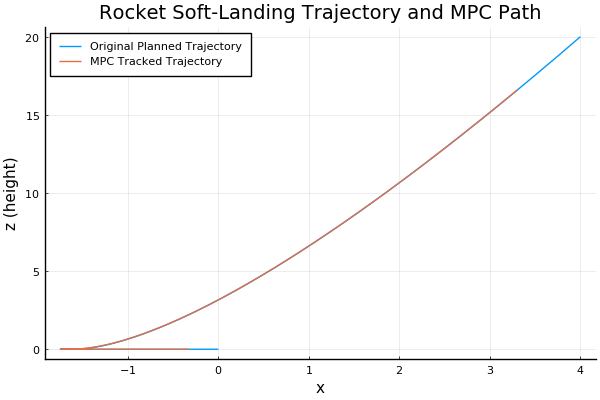

In [21]:
titleText = "Rocket Soft-Landing Trajectory and MPC Path"
filename = "RocketGroundThrustBound_BarelyFeasible3"

plt_x = plot(x_orig, z_orig, label = "Original Planned Trajectory")
plot!(xs, zs, label = "MPC Tracked Trajectory")
xlabel!("x")
ylabel!("z (height)")
title!(titleText)

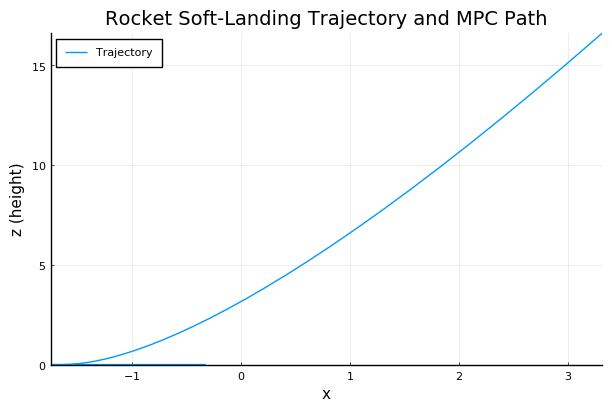

┌ Info: Saved animation to 
│   fn = C:\Users\Daniel N\.julia\dev\altro-mpc-icra2021\benchmarks\rocket_landing\tmp.gif
└ @ Plots C:\Users\Daniel N\.julia\packages\Plots\a7Kbp\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Daniel N\\.julia\\dev\\altro-mpc-icra2021\\benchmarks\\rocket_landing\\tmp.gif")
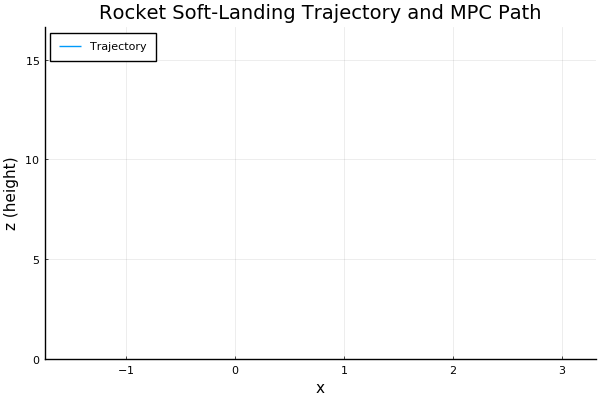

In [22]:
xmin = minimum(xs)
xmax = maximum(xs)

zmin = minimum(zs)
zmax = maximum(zs)

@gif for i in 1:size(xs, 1)
    plt = plot(xs[1:i], zs[1:i], label = "Trajectory", legend = :topleft)
    xlabel!("x")
    ylabel!("z (height)")
    xlims!(xmin,xmax)
    ylims!(zmin,zmax)
    title!(titleText)
end

In [23]:
plt_ux = plot(uxs, label = "Ux Control")
hline!([-ulateral_max, ulateral_max], linecolor = :grey, linestyle = :dash,
                label = "Max Lateral Thrust")
# xlabel!("time (s)")
ylabel!("control (N)")
title!("Controls over Time")

plt_uz = plot(uzs, label = "Uz Control")
hline!([umax], linecolor = :grey, linestyle = :dash, label = "Max Thrust")
xlabel!("time (s)")
ylabel!("control (N)")

plt_u = plot(plt_ux, plt_uz, layout = (2, 1))

UndefVarError: UndefVarError: uxs not defined

Below is a GIF of the trajectory. This will take several seconds to generate.

## Lastly, let's visualize the results in 3D with Meshcat

To do this, we need to provide a Mesh to <code>MeshCat</code>. This is due with <code>FileIO</code> and <code>MeshIO</code>.

In [24]:
vis = Visualizer() # Creates a MeshCat Window
render(vis) # Renders the window below

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://localhost:8700
└ @ MeshCat C:\Users\Daniel N\.julia\packages\MeshCat\X2AUA\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()), Set(Any[]), ip"127.0.0.1", 8700))

In [25]:
function TrajOptPlots._set_mesh!(vis, model::Rocket)
    obj = joinpath(@__DIR__, "SimpleRocket.obj")
    quad_scaling = 0.085
    robot_obj = FileIO.load(obj)
    robot_obj.vertices .*= quad_scaling
    mat = MeshPhongMaterial(color=colorant"lightgrey")
    setobject!(vis["geom"], robot_obj, mat)
end

TrajOptPlots.set_mesh!(vis, model)

MeshCat Visualizer with path /meshcat/robot/geom at http://localhost:8700

In [26]:
Base.position(::Rocket, x::StaticVector) = SA[x[1], x[2], x[3]]
RobotDynamics.orientation(::Rocket, x::StaticVector) = UnitQuaternion(0,0,0,1)

visualize!(vis, altro);

## Integrate the Dynamics to Verify the Dynamics Constraint

In Matlab, we would use ODE 45, but in the <code>DifferentialEquations.jl</code> package we can either (1) just let the <code>solve</code> method figure it out or (2) specify a solver such as <code>Tsit5</code>.

The controls change over time and are discretized. Below, a zero-order hold and a first-order hold are implemented for comparison. **We used a zero-order hold in the optimization so a zero-order hold should be used here.**

In [27]:
get_controls_zero_order_hold(t) = U[min(Int(floor(t/dt)) + 1, size(U,1))]
f(y,p,t) = dynamics(model, y, get_controls_zero_order_hold(t))

states_y0 = x0
tspan = (0.0, tf)
controls_p0 = get_controls_zero_order_hold(tspan[1])

ode_prob_zoh = ODEProblem(f, states_y0, tspan, controls_p0)
@btime solve(ode_prob_zoh, Tsit5(), reltol=1e-10, abstol=1e-10,saveat=dt)
ode_sol_zoh = solve(ode_prob_zoh, Tsit5(), reltol=1e-10, abstol=1e-10,saveat=dt);

  17.820 ms (340663 allocations: 12.94 MiB)


In [28]:
function get_controls_first_order_hold(t)
    # dt and U are both global variables
    tn = t/dt
    
    t_below = Int(max(1, floor(tn)))
    t_above = Int(min(size(U, 1), ceil(tn)))
    
    if t_below >= t_above
        return U[t_below]
    end
    
    slope = (U[t_above] - U[t_below])
    return slope * (tn - t_below) + U[t_below]

end


f(y,p,t) = dynamics(model, y, get_controls_first_order_hold(t))

states_y0 = x0
tspan = (0.0, tf)
controls_p0 = get_controls_first_order_hold(tspan[1])

ode_prob_foh = ODEProblem(f, states_y0, tspan, controls_p0)
@btime solve(ode_prob_foh, Tsit5(), reltol=1e-10, abstol=1e-10,saveat=dt)
ode_sol_foh = solve(ode_prob_foh, Tsit5(), reltol=1e-10, abstol=1e-10,saveat=dt);

  1.358 ms (27652 allocations: 990.26 KiB)


In [29]:
err_zoh = norm.(ode_sol_zoh.u - X[1:(Int(floor(tspan[2]/dt))+1)])
err_foh = norm.(ode_sol_foh.u - X[1:(Int(floor(tspan[2]/dt))+1)])

plot(ode_sol_zoh.t, err_zoh, yaxis = :log, label = "Zero-Order Hold")
plot!(ode_sol_foh.t, err_foh, yaxis = :log, label = "First-Order Hold")
xlabel!("Time (s)")
ylabel!("Dynamics Error")
title!("Comparison in State Vector expected from ALTRO Solver \n to Integrated Dynamics Model")

DimensionMismatch: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(40),), b has dims (Base.OneTo(39),), mismatch at 1")